# Missing Data: A Small Introduction with Example Data


Any data generating process can be messy. From implementation to analysis the project can face countless instances of bias, one bias that becomes extremely prevalent when working with unclean data is **missingness**. Understanding why data is missing, when missing values will occur, and how to handle missing data is critical to meaningful analysis. This notebook provides a quick qualitative explanation of missing data and a structured data example to show how to handle different instances. This is by no means an exhaustive guide on missingness, but should help a new data scientist understand why and how this can affect projects.

## Why Data is Missing & Types of Missingness

First, why could data be missing and what could this mean to our analysis? Here are some reasons:

### 1. Missing Completely at Random (MCAR):
Maybe (and hopefully) somewhere between collecting data, inputting it, and transforming it to analyzable data some observations *randomly* became missing. Maybe during the data collection some respondents just *randomly* skipped over a question. Maybe the research assistant skipped a row on *accident*. 

Regardless of the reason, one idea stays constant and thats the *randomness* of missing observations or variables. In this case it truly was a random accident! 

### 2. Missing at Random (MAR):
Sometimes we'll find missing data not at random but in some observable pattern. This might occur through different groups having different missingness in variables. For instance, imagine data asking different sexes about their safety when walking alone or asking individuals of different nationalities their approval of the government. In these cases you might find women or individuals in autocratic nations not answering the question, leading to high levels of missingness depending on some variable. 

In this case we might see our estimates be heavily biased, in economics this typically manifests as participation bias or survey bias. Typically catching this in field work starts with the survey itself.

### 3. Missing Not at Random (MNAR):
The last (and most problematic) missingness manifests in a systematic way that you can't observe. For example, you have survey data on drug use but without respondent' age. In reality younger adults use more drugs but won't report usage. In your data you see missingness and can't ascertain any observable pattern in it due to lack of age. Again, this will heavily bias your results if not addressed or dropped.




# How to Handle Missing Data

Unfortunately we'll never know if missing data is missing completely at random, at random, or not at random. However with domain expertise and strong statistical knowledge we can venture best guesses to ease the process. 

First we need to ask ourselves a few questions:
1. Is the missingness in a predictor or response?
2. How much missingness is present in the variable? 
3. What type of variable has missingness? Is it continuous, ordinal, categorical?


Second we can tackle the issue head on by...
1. Impute the mean/median (or most common class if categorical) for missing instances.
2. Create a "missing" variable to add into your model, this essentially addresses that the missingness is its own group.
3. "Hot deck imputation": randomly impute observable values for missing values. Possibly do this via bootstrap and calculate the model many times.
4. Predict/Model the missingness and impute with modeled outcome ($X_{missing} = \beta_1X1 + \beta_2X2 + .... \beta_pX_p$)
5. Predict the missingness and impute, but add some randomness in addition to address uncertainty in the guess ($X_{missing} = \beta_1X1 + \beta_2X2 + .... \beta_pX_p + \epsilon$).
6. Drop certain observations that are missing.
7. Drop whole variables if many instances are missing.
8. Give up! (Just kidding, never do that!!)

# Example with Created Data: MCAR v. MCR v. MNAR:
Below has me create data and model each type of missingness to display different outcomes under different missingness scenarios. This is taken from Harvard's Introduction to Data Science.


We create the function:

$$ y = 3x_1 - 2x_2 + \varepsilon,\hspace{0.1in} \varepsilon \sim N(0,1)$$

and impute missingness in the variable `x1` to mirror MCAR, MAR, MNAR.

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression 
from sklearn.impute import SimpleImputer, KNNImputer

In [100]:
# Number of data points to generate
n = 500
# Set random seed for numpy to ensure reproducible results
np.random.seed(109)
# Generate our predictors...
x1 = np.random.normal(0, 1, size=n)
x2 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])
# Generate our response...
y = 3*x1 - 2*x2 + np.random.normal(0, 1, size=n)
y = pd.Series(y)
# And put them all in a nice DataFrame
df = pd.DataFrame(data=np.transpose([x1, x2, y]), columns=["x1", "x2", "y"]) 


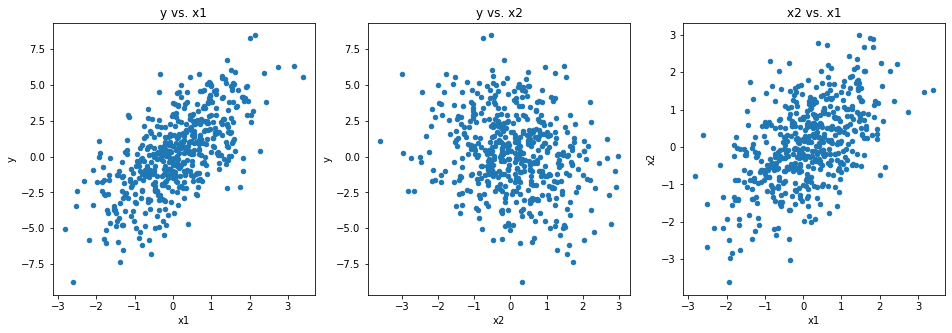

In [101]:
fig, axs =  plt.subplots(1, 3, figsize = (16,5))

plot_pairs = [('x1', 'y'), ('x2', 'y'), ('x1', 'x2')]
for ax, (x_var, y_var) in zip(axs, plot_pairs):
    df.plot.scatter(x_var, y_var, ax=ax, title=f'{y_var} vs. {x_var}')

Text(0.5, 0.92, 'y = x1 + x2 true relationship')

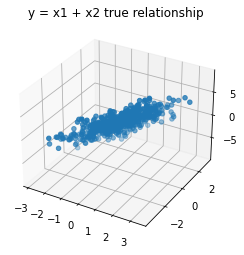

In [102]:
#plot the predicted relationship to see in 3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['x1'], 
          df['x2'],
          df['y'],
          'grey')
ax.set_title("y = x1 + x2 true relationship")


Lets make some missingness, you can see that: 

 __missing_mnar (missing not at random)__ is missing as a function of y, as in, if our observation is greater than the mean + 1 std, then we delete x1. 

__missing_mcar (completely at random)__ we just set 20% to missing randomly.
 
__missing_mar (at random)__ we set missingness as a function of something we can observe and control for x2.

In [103]:
missing_mnar = np.random.binomial(1, 0.05 + 0.85*(y > (y.mean()+y.std())),  n).astype(bool)
missing_mcar = np.random.binomial(1, 0.2, n).astype(bool)
missing_mar = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())), n).astype(bool)

def create_missing(missing_indices, df=df):
    df_new = df.copy()
    df_new.loc[missing_indices, 'x1'] = np.nan
    return df_new

In [104]:
# Missing completely at random (MCAR)
df_mcar = create_missing(missing_indices=missing_mcar)

# Missing at random (MAR)
df_mar = create_missing(missing_indices=missing_mar)

# Missing not at random (MNAR)
df_mnar = create_missing(missing_indices=missing_mnar)

Lets fit our models!

In [105]:
#Actual OLS with no missingness
ols = LinearRegression().fit(df[['x1', 'x2']], df['y'])
print(f'No missing data coefs: b0: {ols.intercept_} \n b1, b2: {ols.coef_}')

No missing data coefs: b0: 0.10204379528391672 
 b1, b2: [ 2.92281015 -1.93658251]


In [106]:
#MCAR
# Fit inside a try/except block just in case...
try:
    ouch = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
except Exception as e:
    print("sklearn does not function with na's! Duh!")
    ols_mcar = LinearRegression().fit(df_mcar.dropna()[['x1', 'x2']], df_mcar.dropna()['y'])
    print(f'No missing data coefs: b0: {ols_mcar.intercept_} \n b1, b2: {ols_mcar.coef_}')
    
    
#Wow pretty close to the true model!

sklearn does not function with na's! Duh!
No missing data coefs: b0: 0.09607569437217287 
 b1, b2: [ 2.95778269 -1.90922895]


In [107]:
#MAR
ols_mar = LinearRegression().fit(df_mar.dropna()[['x1', 'x2']], df_mar.dropna()['y'])
print(f'No missing data coefs: b0: {ols_mar.intercept_} \n b1, b2: {ols_mar.coef_}')

#The values tend closer to 0 in this case

No missing data coefs: b0: 0.1460648111788045 
 b1, b2: [ 2.93256228 -1.89351279]


In [108]:
#MNAR
ols_mnar = LinearRegression().fit(df_mnar.dropna()[['x1', 'x2']], df_mnar.dropna()['y'])

print(f'No missing data coefs: b0: {ols_mnar.intercept_} \n b1, b2: {ols_mnar.coef_}')

#Even more biased towards 0!

No missing data coefs: b0: 0.02022128332556078 
 b1, b2: [ 2.77095031 -1.84859735]


## Address Missingness:

In [109]:
# Make backup copies for later since we'll have lots of imputation approaches.
X_mcar_raw = df_mcar.drop('y', axis=1).copy()
X_mar_raw = df_mar.drop('y', axis=1).copy()
X_mnar_raw = df_mnar.drop('y', axis=1).copy()

final_df = pd.DataFrame({'Name': '',
                        'Intercept': 0,
                         'x1 coef': 0,
                         'x2_coef': 0},
                        index = range(1,15))


final_df.loc[1]=['True Model',ols.intercept_, ols.coef_[0], ols.coef_[1]]
final_df.loc[2]=['MCAR - Drop Missing',ols_mcar.intercept_, ols_mcar.coef_[0], ols_mcar.coef_[1]]
final_df.loc[3]=['MAR - Drop Missing',ols_mar.intercept_, ols_mar.coef_[0], ols_mar.coef_[1]]
final_df.loc[4]=['MNAR - Drop Missing',ols_mnar.intercept_, ols_mnar.coef_[0], ols_mnar.coef_[1]]
i=4

### 1. Impute the mean or median:

In [110]:
# Here's an example of one way to do the mean imputation with the above methods
loop_dict = { 'MCAR': X_mcar_raw,
             'MAR': X_mar_raw,
             'MNAR': X_mnar_raw
    }

for key,val in loop_dict.items():
    copy_df = val.copy()
    copy_df['x1'] = copy_df['x1'].fillna(copy_df['x1'].dropna().mean())

    ols = LinearRegression().fit(copy_df, y)
    print(key, ols.intercept_, ols.coef_)
    
    i+=1 
    final_df.loc[i] = [key+'- Mean:' ,ols.intercept_, ols.coef_[0], ols.coef_[1]]



MCAR 0.06518722125657417 [ 2.76751051 -1.56434888]
MAR 0.3922738786668911 [ 2.62546455 -1.22434111]
MNAR 0.520706160894387 [ 2.64232555 -1.67075578]


In [111]:
#we can do the sample with simpleimputer

imputer = SimpleImputer()

for key,val in loop_dict.items():
    copy_df = val.copy()
    copy_df = imputer.fit_transform(copy_df)
    ols = LinearRegression().fit(copy_df, y)

    print(key, ols.intercept_, ols.coef_)


MCAR 0.06518722125657414 [ 2.76751051 -1.56434888]
MAR 0.3922738786668911 [ 2.62546455 -1.22434111]
MNAR 0.520706160894387 [ 2.64232555 -1.67075578]


Overall imputing the mean value and running OLS sets our coefficients further from the true value!

### 2. Linear Regression Imputation:

This is in reference to the 7th and 8th suggestions to deal with missing variables.

Here we'll regress `x1` on `x2`, store the predicted values. Then we'll regress `y` on `x1_predicted` & `x2`.

In [112]:
for key,val in loop_dict.items():
    copy_df = val.copy()
    ols = LinearRegression().fit(copy_df.dropna()[['x2']],copy_df.dropna()['x1'])
    x1_predicted = pd.Series(ols.predict(copy_df[['x2']]))

    #Now lets replace NA x1 with the predicted values
    copy_df['x1'] = copy_df['x1'].fillna(x1_predicted)
    
    #fit and report
    ols = LinearRegression().fit(copy_df, y)
    print(key, ols.intercept_, ols.coef_)
    
    i+=1 
    final_df.loc[i] = [key+'- OLS:' ,ols.intercept_, ols.coef_[0], ols.coef_[1]]
    

    
#Wow much better than imputing the mean!

MCAR 0.11835122909536355 [ 2.95778269 -1.91346654]
MAR 0.007334836526979499 [ 2.93256228 -1.99438598]
MNAR 0.6148065869266275 [ 2.77095031 -1.97302957]


### $k$-NN Imputation ($k$=3)
Instead of OLS we could try to impute missing data with K-NN, using nearby, available x1's to impute the missing one. Lets try!

In [113]:

for key,val in loop_dict.items():
    copy_df = val.copy()
    copy_df = KNNImputer(n_neighbors=3).fit_transform(copy_df)
    
    ols = LinearRegression().fit(copy_df, y)
    
    print(key, ols.intercept_, ols.coef_)
    i+=1 
    final_df.loc[i] = [key+'- KNN = 3:' ,ols.intercept_, ols.coef_[0], ols.coef_[1]]




MCAR 0.15134915515799063 [ 2.78459666 -1.85426345]
MAR 0.24560978941317946 [ 2.72661518 -1.55667191]
MNAR 0.6358511234519548 [ 2.62065071 -1.93067768]


## Results from All Models:

It seems that imputing with the mean does worst, while dropping missing or using OLS works best.

In [116]:
final_df.drop([14])

,Name,Intercept,x1 coef,x2_coef
1,True Model,0.102044,2.922810,-1.936583
2,MCAR - Drop Missing,0.096076,2.957783,-1.909229
3,MAR - Drop Missing,0.146065,2.932562,-1.893513
4,MNAR - Drop Missing,0.020221,2.770950,-1.848597
5,MCAR- Mean:,0.065187,2.767511,-1.564349
6,MAR- Mean:,0.392274,2.625465,-1.224341
7,MNAR- Mean:,0.520706,2.642326,-1.670756
8,MCAR- OLS:,0.118351,2.957783,-1.913467
9,MAR- OLS:,0.007335,2.932562,-1.994386
10,MNAR- OLS:,0.614807,2.770950,-1.973030
